In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import tensorflow as tf
import selfies as sf
import counterstone as cs
from dataclasses import dataclass
from rdkit.Chem.Draw import rdDepictor
rdDepictor.SetPreferCoordGen(True)
sns.set_context('notebook')
sns.set_style('dark',  {'xtick.bottom':True, 'ytick.left':True, 'xtick.color': '#666666', 'ytick.color': '#666666',
                        'axes.edgecolor': '#666666', 'axes.linewidth':     0.8 , 'figure.dpi': 300})
color_cycle = ['#1BBC9B', '#F06060', '#5C4B51', '#F3B562', '#6e5687']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_cycle) 
soldata = pd.read_csv('https://github.com/whitead/dmol-book/raw/master/data/curated-solubility-dataset.csv')
features_start_at = list(soldata.columns).index('MolWt')
np.random.seed(0)

2021-08-10 14:31:04.215108: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# scramble them
soldata = soldata.sample(frac=1, random_state=0).reset_index(drop=True)
soldata.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,B-4206,diuron,InChI=1S/C9H10Cl2N2O/c1-13(2)9(14)12-6-3-4-7(1...,XMTQQYYKAHVGBJ-UHFFFAOYSA-N,CN(C)C(=O)Nc1ccc(Cl)c(Cl)c1,-3.744300,1.227164,5,G4,233.098,...,1.0,76.0,1.0,0.0,0.0,1.0,32.34,92.603980,2.781208,352.665233
1,F-988,7-(3-amino-3-methylazetidin-1-yl)-8-chloro-1-c...,InChI=1S/C17H17ClFN3O3/c1-17(20)6-21(7-17)14-1...,DUNZFXZSFJLIKR-UHFFFAOYSA-N,CC1(N)CN(C2=C(Cl)C3=C(C=C2F)C(=O)C(C(=O)O)=CN3...,-5.330000,0.000000,1,G1,365.792,...,3.0,132.0,2.0,2.0,2.0,4.0,88.56,147.136366,2.001398,973.487509
2,C-1996,4-acetoxybiphenyl; 4-biphenylyl acetate,InChI=1S/C14H12O2/c1-11(15)16-14-9-7-13(8-10-1...,MISFQCBPASYYGV-UHFFFAOYSA-N,CC(=O)OC1=CC=C(C=C1)C2=CC=CC=C2,-4.400000,0.000000,1,G1,212.248,...,2.0,80.0,2.0,0.0,0.0,2.0,26.30,94.493449,2.228677,471.848345
3,A-3055,methane dimolybdenum,InChI=1S/CH4.2Mo/h1H4;;,JAGQSESDQXCFCH-UHFFFAOYSA-N,C.[Mo].[Mo],-3.420275,0.409223,2,G3,207.923,...,0.0,20.0,0.0,0.0,0.0,0.0,0.00,49.515427,-0.000000,2.754888
4,A-2575,ethyl 4-[[(methylphenylamino)methylene]amino]b...,InChI=1S/C17H18N2O2/c1-3-21-17(20)14-9-11-15(1...,GNGYPJUKIKDJQT-UHFFFAOYSA-N,CCOC(=O)c1ccc(cc1)N=CN(C)c2ccccc2,-5.450777,0.000000,1,G1,282.343,...,5.0,108.0,2.0,0.0,0.0,2.0,41.90,124.243431,2.028889,606.447052


In [3]:
selfies_list = [sf.encoder(cs.sanitize_smiles(s)[1]) for s in soldata.SMILES]

In [4]:
vocab = list(sf.get_alphabet_from_selfies([s for s in selfies_list if s is not None]))
vocab_stoi = {o:i for o,i in zip(vocab, range(len(vocab)))}
print('Vocab size', len(vocab))

def selfies2ints(s):
    result = []
    for token in sf.split_selfies(s):
        if token == '.':
            continue #?
        if token in vocab_stoi:
            result.append(vocab_stoi[token])
        else:
            result.append(np.nan)
            #print('Warning')
    return result
def ints2selfies(v):
    return ''.join([vocab[i] for i in v])

# test them out
s = selfies_list[0]
print('selfies:', s)
v = selfies2ints(s)
print('selfies2ints:', v)
so = ints2selfies(v)
print('ints2selfes:', so)
assert so == s

Vocab size 206
selfies: [C][N][Branch1_1][C][C][C][Branch1_2][C][=O][N][C][=C][C][=C][Branch1_1][C][Cl][C][Branch1_1][C][Cl][=C][Ring1][Branch2_1]
selfies2ints: [145, 184, 90, 145, 145, 145, 194, 145, 22, 184, 145, 143, 145, 143, 90, 145, 180, 145, 90, 145, 180, 143, 63, 122]
ints2selfes: [C][N][Branch1_1][C][C][C][Branch1_2][C][=O][N][C][=C][C][=C][Branch1_1][C][Cl][C][Branch1_1][C][Cl][=C][Ring1][Branch2_1]


In [5]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    embedding_dim: int
    rnn_units: int
    hidden_dim: int
        
config = Config(vocab_size=len(vocab), 
                example_number=len(selfies_list), 
                batch_size=16, 
                buffer_size=10000, 
                embedding_dim=256, 
                hidden_dim=128,
                rnn_units=128)

In [6]:
# now get sequences
encoded = [selfies2ints(s) for s in selfies_list if s is not None]
padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding='post')

# Now build dataset
data = tf.data.Dataset.from_tensor_slices((padded_seqs, soldata.Solubility.iloc[[bool(s) for s in selfies_list]].values))
# now split into val, test, train and batch
N = len(data)  
split = int(0.1 * N)
test_data = data.take(split).batch(config.batch_size)
nontest = data.skip(split)
val_data, train_data = nontest.take(split).batch(config.batch_size), \
    nontest.skip(split).shuffle(config.buffer_size).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

2021-08-10 14:31:23.833806: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-10 14:31:43.233493: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:ca:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2021-08-10 14:31:43.233539: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-10 14:31:43.291541: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-10 14:31:43.291613: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-10 14:31:43.292841: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

In [24]:
model = tf.keras.Sequential()

# make embedding and indicate that 0 should be treated as padding mask
model.add(tf.keras.layers.Embedding(input_dim=config.vocab_size, output_dim=config.embedding_dim, mask_zero=True))

# RNN layer
model.add(tf.keras.layers.GRU(config.rnn_units))
# a dense hidden layer
model.add(tf.keras.layers.Dense(config.hidden_dim, activation='relu'))
# regression, so no activation
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         52736     
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               148224    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 217,601
Trainable params: 217,601
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(tf.optimizers.Adam(1e-4), loss='mean_squared_error')
result = model.fit(train_data, validation_data=val_data, epochs=100, verbose=1)

Epoch 1/100
500/500 [==============================] - 9s 12ms/step - loss: 4.6561 - val_loss: 2.7743
Epoch 2/100
500/500 [==============================] - 5s 11ms/step - loss: 2.4898 - val_loss: 2.5555
Epoch 3/100
500/500 [==============================] - 5s 10ms/step - loss: 2.2507 - val_loss: 2.3984
Epoch 4/100
500/500 [==============================] - 5s 10ms/step - loss: 2.1488 - val_loss: 2.2977
Epoch 5/100
500/500 [==============================] - 5s 10ms/step - loss: 2.0819 - val_loss: 2.3635
Epoch 6/100
500/500 [==============================] - 5s 10ms/step - loss: 2.0287 - val_loss: 2.3570
Epoch 7/100
500/500 [==============================] - 5s 10ms/step - loss: 1.9675 - val_loss: 2.2129
Epoch 8/100
500/500 [==============================] - 5s 10ms/step - loss: 1.9555 - val_loss: 2.2579
Epoch 9/100
500/500 [==============================] - 5s 10ms/step - loss: 1.9027 - val_loss: 2.3784
Epoch 10/100
500/500 [==============================] - 5s 10ms/step - loss: 1.840

500/500 [==============================] - 5s 10ms/step - loss: 0.9715 - val_loss: 1.5648
Epoch 81/100
500/500 [==============================] - 5s 10ms/step - loss: 0.9629 - val_loss: 1.5673
Epoch 82/100
500/500 [==============================] - 5s 10ms/step - loss: 0.9624 - val_loss: 1.5674
Epoch 83/100
500/500 [==============================] - 5s 10ms/step - loss: 0.9515 - val_loss: 1.5457
Epoch 84/100
500/500 [==============================] - 5s 10ms/step - loss: 0.9533 - val_loss: 1.5482
Epoch 85/100
500/500 [==============================] - 5s 10ms/step - loss: 0.9411 - val_loss: 1.5454
Epoch 86/100
500/500 [==============================] - 5s 10ms/step - loss: 0.9323 - val_loss: 1.6378
Epoch 87/100
500/500 [==============================] - 5s 10ms/step - loss: 0.9346 - val_loss: 1.5916
Epoch 88/100
500/500 [==============================] - 5s 10ms/step - loss: 0.9254 - val_loss: 1.5839
Epoch 89/100
500/500 [==============================] - 5s 10ms/step - loss: 0.9261 - 

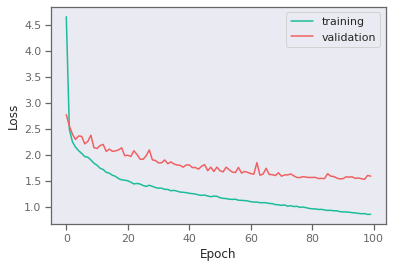

In [26]:
plt.plot(result.history['loss'], label='training')
plt.plot(result.history['val_loss'], label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

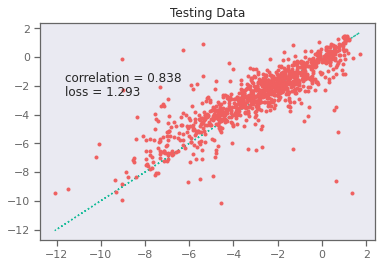

In [47]:
yhat = []
test_y = []
for x,y in test_data:
    yhat.extend(model(x).numpy().flatten())
    test_y.extend(y.numpy().flatten())
yhat = np.array(yhat)
test_y = np.array(test_y)

# plot test data
plt.plot(test_y, test_y, ':')
plt.plot(test_y, yhat, '.')
plt.text(min(y) - 7, max(y) - 2, f'correlation = {np.corrcoef(test_y, yhat)[0,1]:.3f}')
plt.text(min(y) - 7, max(y) - 3, f'loss = {np.sqrt(np.mean((test_y - yhat)**2)):.3f}')
plt.title('Testing Data')
plt.savefig('rnn-fit.png', dpi=300)
plt.show()


## CF explanation:

In the following example let's say we would like our molecules to return a solubility value of -3.5. Here we use `counterstone` algorithm to create counter factual explanations. In other words, we would like to see what are the minimal mutations that could to be done to our input structure to get our desired solubility.

In [28]:
def predictor_function(smile_list,selfies):
    encoded = [selfies2ints(s) for s in selfies]
    # check for nans
    valid = [1. if sum(e) > 0 else np.nan for e in encoded]
    encoded = [np.nan_to_num(e, nan=0) for e in encoded]
    padded_seqs = tf.keras.preprocessing.sequence.pad_sequences(encoded, padding='post')
    labels = np.reshape(model.predict(padded_seqs), (-1))
    return labels * valid

In [29]:
predictor_function([], ['[C][#S-expl]', '[C]'])

array([        nan, -1.25675154])

In [30]:
stoned_kwargs={'num_samples': 2500, 'alphabet':cs.get_basic_alphabet(), 'max_mutations': 2}
space = cs.sample_space(soldata.SMILES[4], predictor_function, stoned_kwargs=stoned_kwargs)

STONED Round Complete with 2500
STONED Round Complete with 2500


In [31]:
exps = cs.regression_explain(space, 0.5, nmols=4)

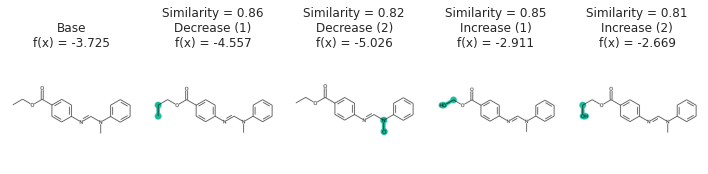

In [32]:
fkw = {'figsize': (10,3)}
cs.plot_explanation(exps, figure_kwargs=fkw, mol_size=(450,400), nrows=1)
plt.savefig('rnn-simple.png',  bbox_inches='tight', dpi=180)

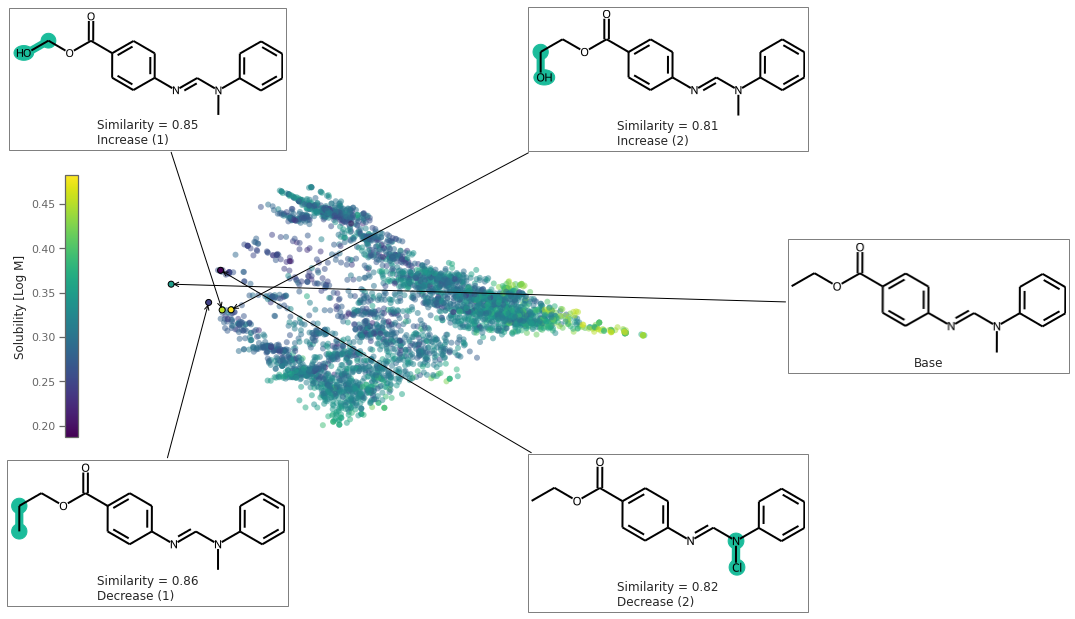

In [33]:
fkw = {'figsize': (10,4)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

cs.plot_space(space, exps, figure_kwargs=fkw, mol_size=(300,200), offset=1)
plt.colorbar(location='left', label='Solubility [Log M]')
plt.tight_layout()
plt.savefig('rnn-space.png', bbox_inches='tight', dpi=180)

STONED Round Complete with 600
STONED Round Complete with 600
STONED Round Complete with 600
STONED Round Complete with 600
STONED Round Complete with 600


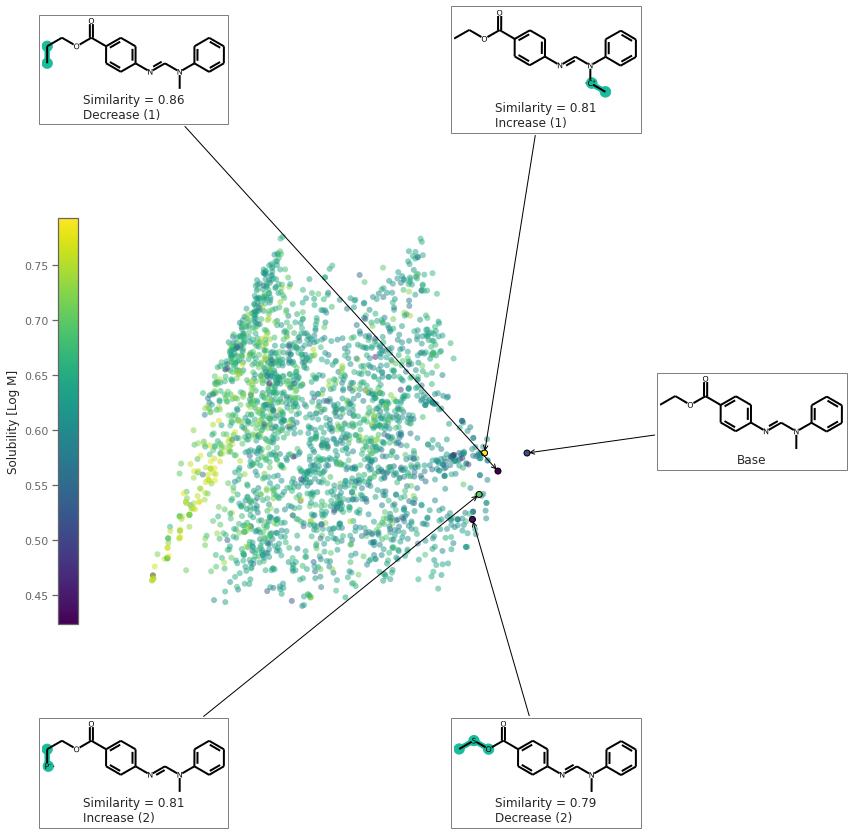

In [34]:
space = cs.sample_space(soldata.SMILES[4], predictor_function, preset='wide')
exps = cs.regression_explain(space, 0.5)
fkw = {'figsize': (8,6)}
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

cs.plot_space(space, exps, figure_kwargs=fkw, mol_size=(200,200), offset=1)
plt.colorbar(location='left', label='Solubility [Log M]')
plt.tight_layout()
plt.savefig('rnn-wide.png', bbox_inches='tight', dpi=180)

## Figure showing effect of mutation number and Alphabet


In [35]:
exps = []
spaces = []
for i in [1,3,5]:
    stoned_kwargs={'num_samples': 2500, 'alphabet':cs.get_basic_alphabet(),'min_mutations':i, 'max_mutations': i}
    space = cs.sample_space(soldata.SMILES[4], predictor_function, stoned_kwargs=stoned_kwargs)
    spaces.append(space)
    e = cs.regression_explain(space, nmols=2)
    if len(exps) == 0:
        exps.append(e[0])
    for ei in e:
        if not ei.is_origin and 'Decrease' in ei.label:
            ei.label = f'Mutations = {i}'
            exps.append(ei)
            break

STONED Round Complete with 2500
STONED Round Complete with 2500
STONED Round Complete with 2500


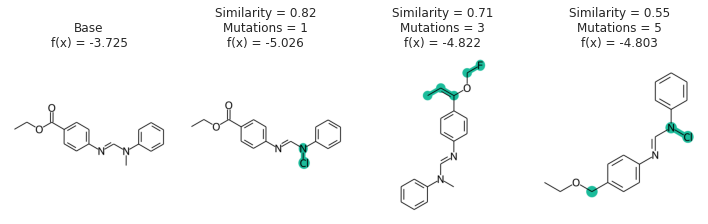

In [36]:
fkw = {'figsize': (10, 4)}
cs.plot_explanation(exps, figure_kwargs=fkw, mol_fontsize=26, mol_size=(400,400), nrows=1)
plt.savefig('rnn-mutations.png', bbox_inches='tight', dpi=180)

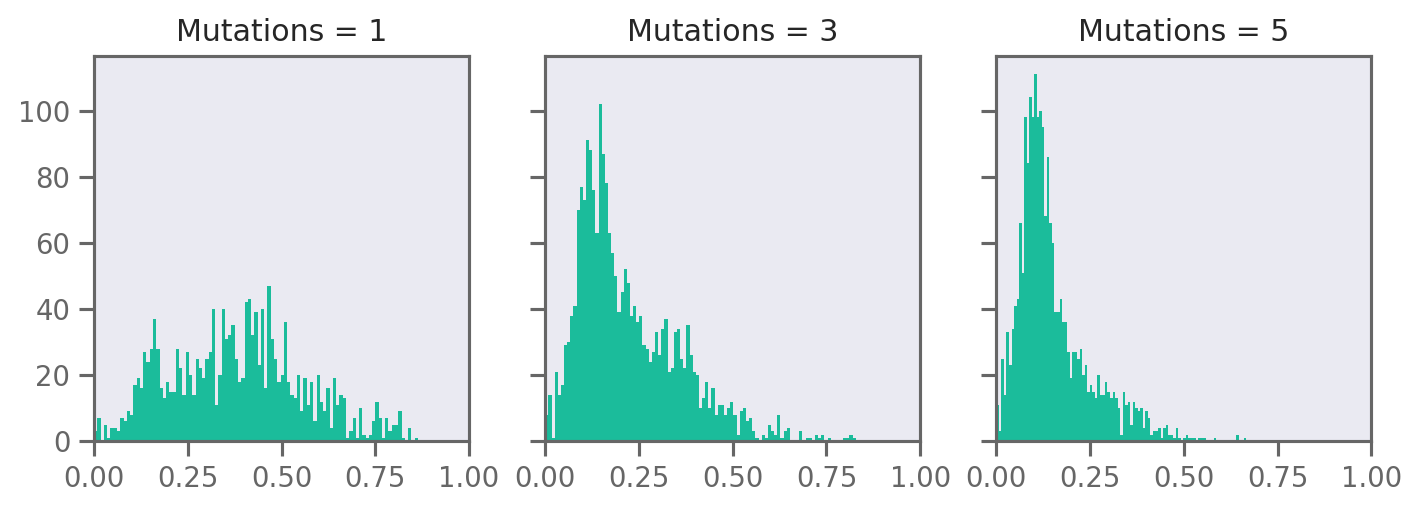

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(8,3), dpi=180, squeeze=True, sharey=True)
for i,n in enumerate([1,3,5]):
    axs[i].hist([e.similarity for e in spaces[i][1:]], bins=99,edgecolor='none')
    axs[i].set_title(f'Mutations = {n}')
    axs[i].set_xlim(0,1)
plt.tight_layout()
plt.savefig('rnn-mutation-hist.png', bbox_inches='tight', dpi=180)

In [38]:
basic = cs.get_basic_alphabet()
train = sf.get_alphabet_from_selfies(selfies_list)
wide = sf.get_semantic_robust_alphabet()

alphs = {'Basic': basic, 'Training Data': train, 'SELFIES': wide}

exps = []
for l,a in alphs.items():
    stoned_kwargs={'num_samples': 2500//2, 'alphabet':a, 'max_mutations': 2}
    space = cs.sample_space(soldata.SMILES[4], predictor_function, stoned_kwargs=stoned_kwargs)
    e = cs.regression_explain(space, nmols=2)
    if len(exps) == 0:
        exps.append(e[0])
    for ei in e:
        if not ei.is_origin and 'Decrease' in ei.label:
            ei.label = f'Alphabet = {l}'
            exps.append(ei)
            break

STONED Round Complete with 1250
STONED Round Complete with 1250
STONED Round Complete with 1250
STONED Round Complete with 1250
STONED Round Complete with 1250
STONED Round Complete with 1250


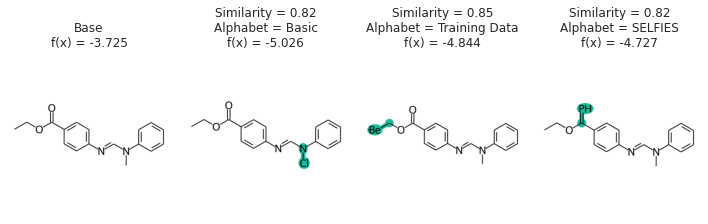

In [39]:
fkw = {'figsize': (10, 4)}
cs.plot_explanation(exps, figure_kwargs=fkw, mol_fontsize=26, mol_size=(400,400), nrows=1)
plt.savefig('rnn-alphabets.png', bbox_inches='tight', dpi=180)